In [1]:
import pickle
import pandas as pd

# Load the DataFrame
df = pd.read_pickle("cleaned.pkl")

In [2]:
# Reset display options to default values
pd.reset_option('all')

# Now, when you display your DataFrame, it will show all rows and columns without truncation
df['entities']

C:\Users\Rithik Vijay\AppData\Local\Temp\ipykernel_1392\3924713156.py:2: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\Rithik Vijay\AppData\Local\Temp\ipykernel_1392\3924713156.py:2: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


0    [(wandsworth prison, PERSON), (the prison and ...
Name: entities, dtype: object

In [3]:
import networkx as nx

# Initialize a directed graph
G = nx.DiGraph()

# Function to add entities and their relationships to the graph
def add_to_graph(entities):
    previous_entity = None
    for ent in entities:
        entity_name, entity_type = ent
        
        # Add the node with its label as an attribute
        if not G.has_node(entity_name):
            G.add_node(entity_name, label=entity_type)
        
        # Add an edge between the current entity and the previous entity if applicable
        if previous_entity:
            G.add_edge(previous_entity, entity_name)
        
        # Update the previous entity
        previous_entity = entity_name

# Apply the function to each row in the DataFrame
df['entities'].apply(add_to_graph)

0    None
Name: entities, dtype: object

In [4]:
# Save the knowledge graph to a file
with open("knowledge_graph.gpickle", "wb") as f:
    pickle.dump(G, f)

print("Knowledge graph created and saved to knowledge_graph.gpickle")

Knowledge graph created and saved to knowledge_graph.gpickle


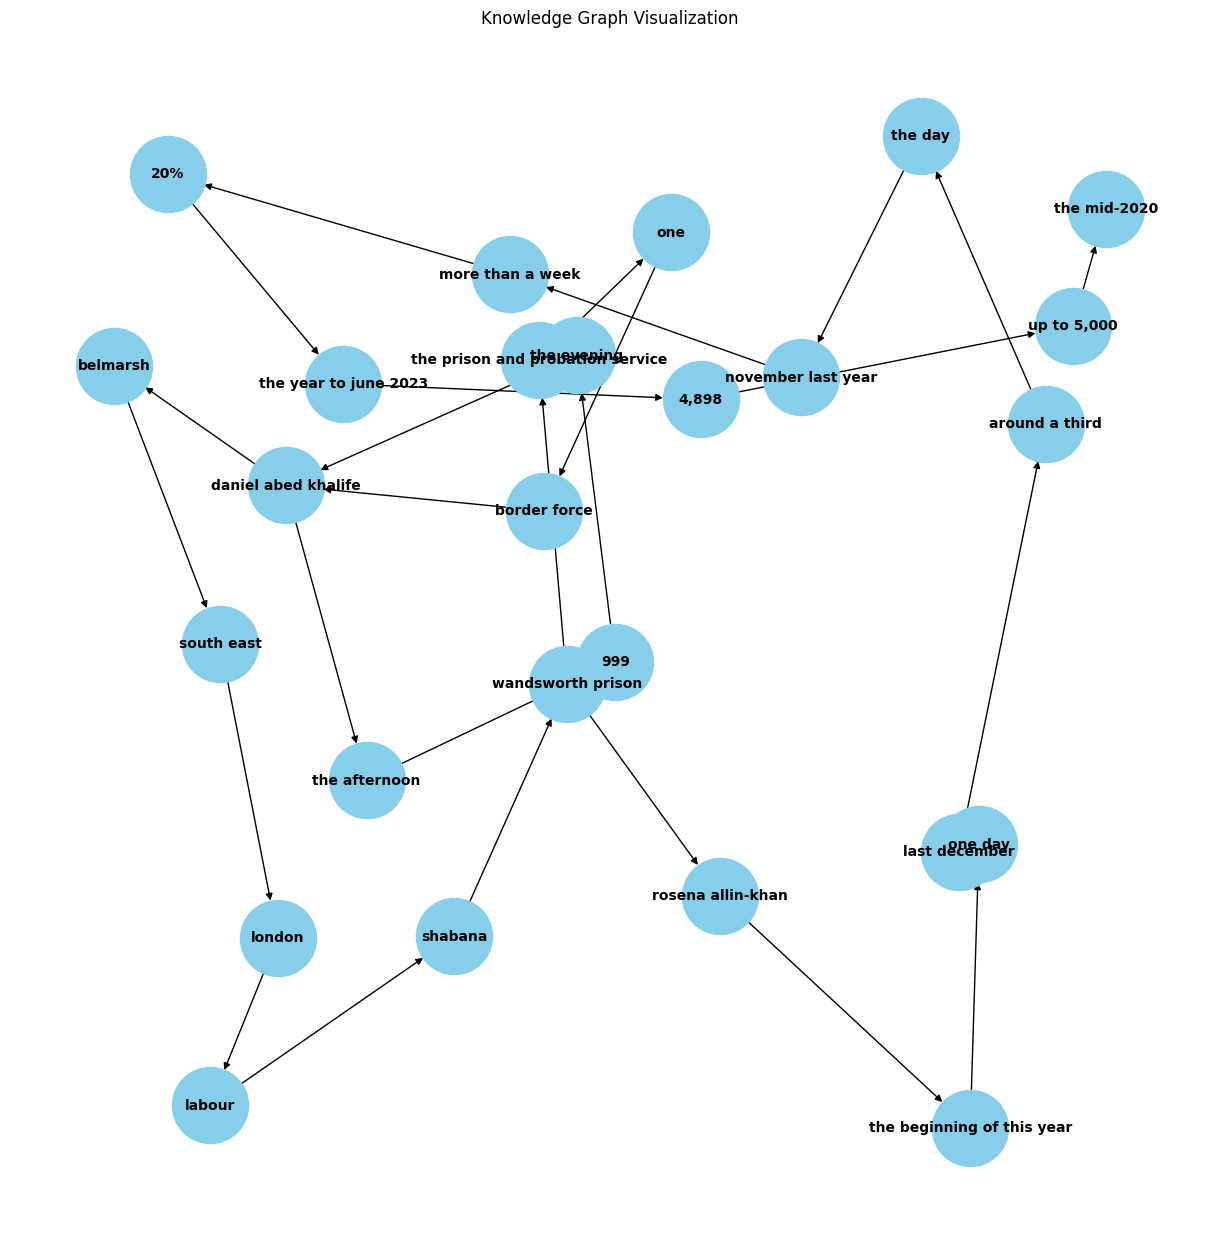

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Load the knowledge graph
with open("knowledge_graph.gpickle", "rb") as f:
    G = pickle.load(f)

# Visualize a subgraph (if the graph is too large)
subgraph = nx.subgraph(G, list(G.nodes)[:50])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph, k=0.5)
nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold")
plt.title("Knowledge Graph Visualization")
plt.show()

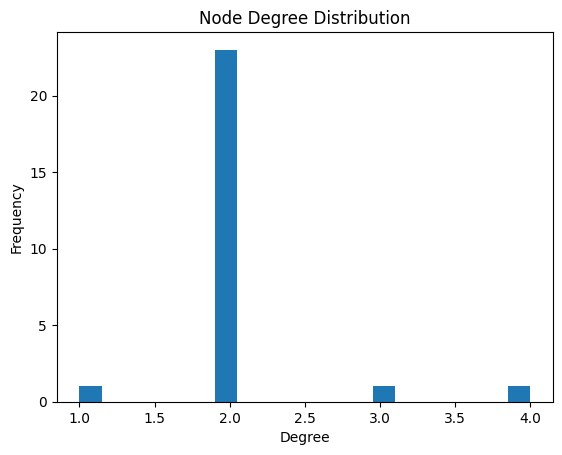

In [6]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
plt.hist(degree_sequence, bins=20)
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


In [7]:
num_components = nx.number_connected_components(G.to_undirected())
print(f"Number of connected components: {num_components}")


Number of connected components: 1


In [8]:
clustering_coeff = nx.average_clustering(G)
print(f"Average clustering coefficient: {clustering_coeff:.4f}")


Average clustering coefficient: 0.0000


In [58]:
# Function to inspect a node and its neighbors
def inspect_node(node):
    if node in G:
        neighbors = list(G.neighbors(node))
        print(f"Node: {node}")
        print(f"Neighbors: {neighbors}")
    else:
        print(f"Node '{node}' not found in the graph.")

# Example usage
inspect_node("doha")  # Replace with an actual entity name from your data


Node: doha
Neighbors: ['doha', 'international centre for sport security', 'monday']


In [13]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")

# Function to extract entities from a question
def extract_entities(question):
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents]
    return entities

# Example question
question = "What happened in Wandsworth Prison?"

# Extract entities from the question
entities = extract_entities(question)
print(f"Extracted Entities: {entities}")


ValueError: [E002] Can't find factory for 'curated_transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer

In [10]:
# Function to create a context from the knowledge graph
def create_context(entities, graph):
    context = ""
    for entity in entities:
        entity = entity.lower()
        if graph.has_node(entity):
            neighbors = list(graph.neighbors(entity))
            context += f"{entity} is related to: " + ", ".join(neighbors) + ". "
    return context

# Generate context for the question
context = create_context(entities, G)
print(f"Generated Context: {context}")


Generated Context: wandsworth prison is related to: the prison and probation service, rosena allin-khan. 


In [11]:
from transformers import pipeline

# Load the pre-trained question answering pipeline
qa_pipeline = pipeline("question-answering")

# Function to answer the question using the QA model
def answer_question(question, context):
    if not context:
        return "I don't have enough information to answer that question."
    
    # Use the QA model to answer the question
    result = qa_pipeline(question=question, context=context)
    return result['answer']

# Answer the question
answer = answer_question(question, context)
print(f"Answer: {answer}")


c:\Users\Rithik Vijay\Documents\GitHub\LifeHack\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\Rithik Vijay\Documents\GitHub\LifeHack\venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Answer: the prison and probation service
